
The notebook covers Following Topics

- Missing Value Analysis
- Correlation Analysis
- Top Contributing Features (Through XGBoost)
- PCA
- In progress

Data is not consistently used as file intended as test has been temporarily withdrawn,changes will be made as soon
as it's available.'

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from scipy.stats import kendalltau
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import warnings
matplotlib.style.use("ggplot")
#pd.options.mode.changed_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

Reading In Dataset
training file and property for 2016. Will be merging the two to create an efficient document to test errors on

In [2]:
train = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])

In [3]:
train.columns

Index(['parcelid', 'logerror', 'transactiondate'], dtype='object')

In [4]:
properties = pd.read_csv("properties_2016.csv", low_memory = True)

c:\users\monika\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

Shape of Dataset

In [6]:
print ('shape of training set: ', train.shape)
print ('shape of properties dataframe: ', properties.shape)

shape of training set:  (90275, 3)
shape of properties dataframe:  (2985217, 58)


Merge 'Train' and 'Properties' for EDA

In [7]:
merged = pd.merge(train,properties,on="parcelid",how="left")

In [8]:
print ('shape of merged: ', merged.shape)

shape of merged:  (90275, 60)


In [9]:
merged.head(4).transpose()

,0,1,2,3
parcelid,11016594,14366692,12098116,12643413
logerror,0.0276,-0.1684,-0.004,0.0218
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-02 00:00:00
airconditioningtypeid,1,NaN,1,1
architecturalstyletypeid,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN
bathroomcnt,2,3.5,3,2
bedroomcnt,3,4,2,2
buildingclasstypeid,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4,4


Visualising Datatypes

In [22]:
pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"Variable Type", 0:"Count"})

,Variable Type,Count
0,object,58
1,float64,1
2,datetime64[ns],1


In [10]:
dataType = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"Variable Type", 0:"Count"})

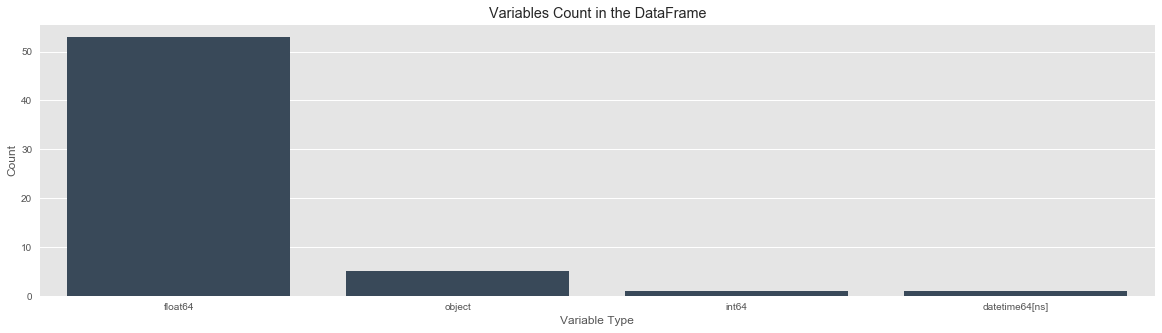

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.barplot(data=dataType, x = "Variable Type", y = "Count", ax = ax, color="#34495e")
ax.set(xlabel = "Variable Type", ylabel = "Count", title = "Variables Count in the DataFrame")

Missing Value Analysis

In [12]:
### Calculate number of missing values per column
missingValueColumns = merged.columns[merged.isnull().any()].tolist()

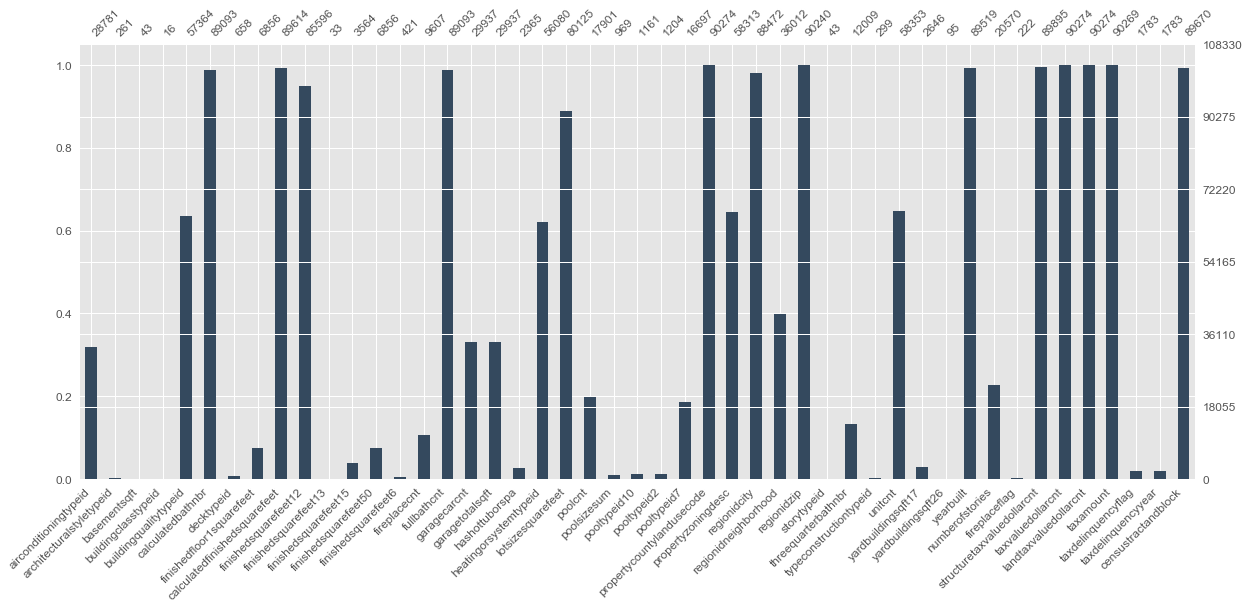

In [13]:
### Right hand axis shows value figure, minor axis by 18,055
### Count showing missing values by column
msno.bar(merged[missingValueColumns], figsize=(20,8),color="#34495e",fontsize=12,labels=True,)

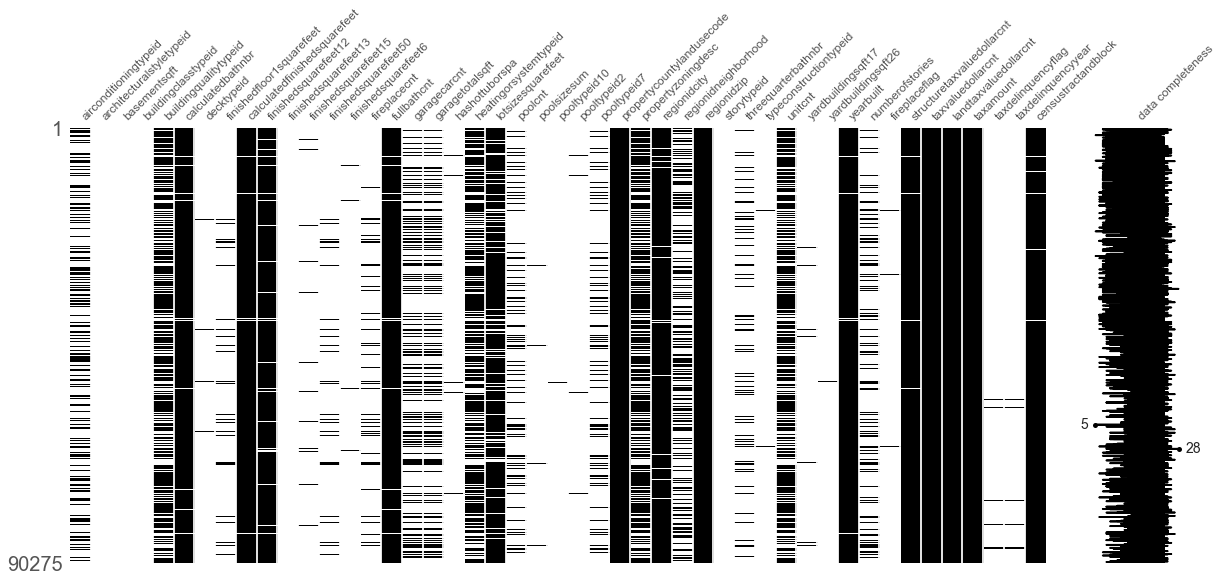

In [14]:
### Missing data demonstrated by column density
msno.matrix(merged[missingValueColumns],width_ratios=(10,1),\
            figsize=(20,8),color=(0,0, 0),fontsize=12,sparkline=True,labels=True)

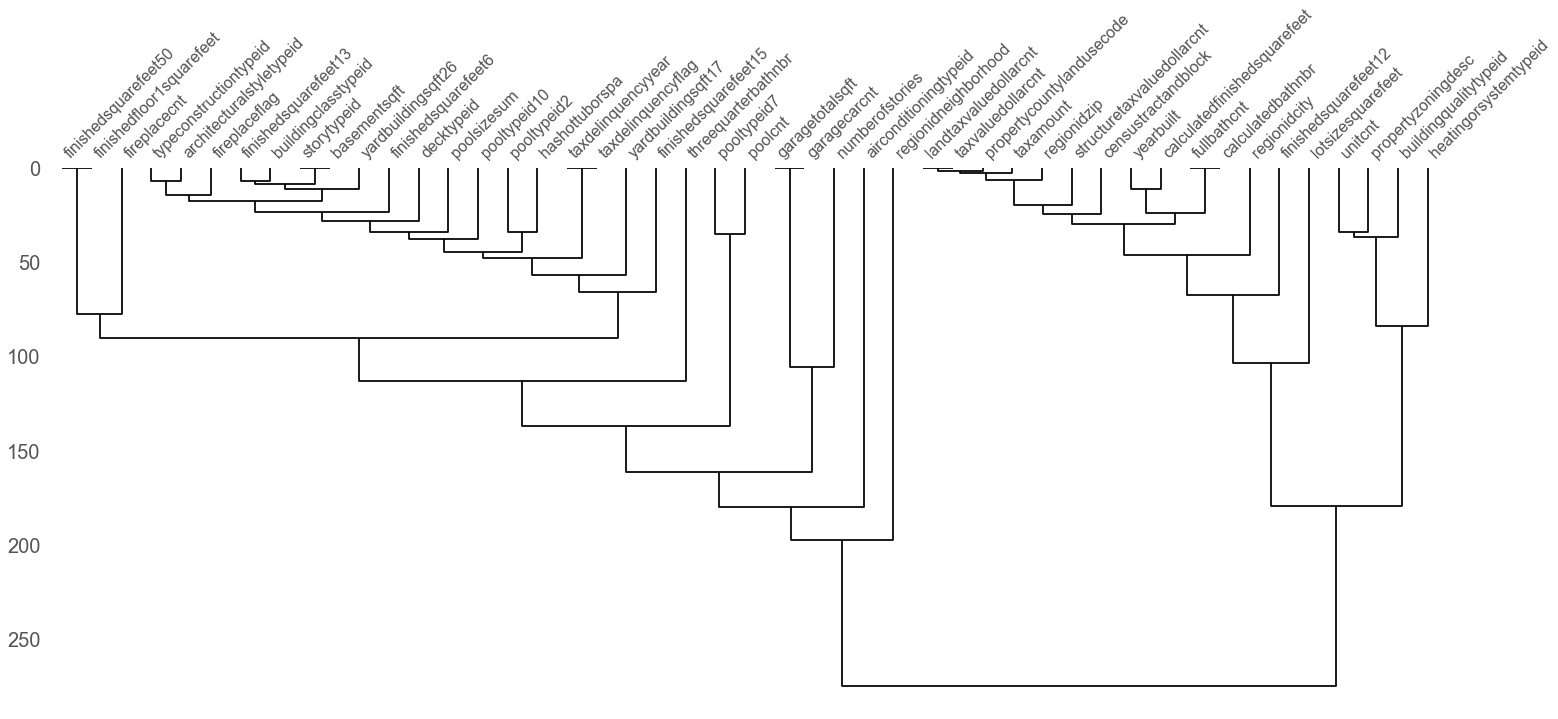

In [15]:
### Shows taxonomic relationships:
msno.dendrogram(merged[missingValueColumns])

### Top Features Selection

### Under Construction, xgboost parameters are being calculated

Chen, He: Higgs Boson Discovery with Boost Trees; JMLR: Workshop and Conference Proceedings 42:69-80, 2015

http://proceedings.mlr.press/v42/chen14.pdf

"Ours differs from the traditional gradient boosting method by introducing a regularization term to penalize the 2
complexity of the function, making the result more robust to overfitting.  The advantage of regularizing boosted 
trees is also discussed in   (Johnson and Zhang, 2014)." 

Rie Johnson and Tong Zhang. Learning nonlinear functions using regularized greedy forest. Pattern Analysis and 
Machine Intelligence, IEEE Transactions on, 36(5):942–954, 2014. https://arxiv.org/pdf/1109.0887.pdf

In [101]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

Practical advice on xgboost from Kaggle competitors

http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

Tiangi Chen, Carlos Guestrin "XGBoost: A Scalable Tree Boosting System"

http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf
    
"We propose a novel sparsity-aware algorithm for sparse data and weighted quantile sketch for approximate tree learning.  
More importantly, we provide insights on cache access patterns, data compression and sharding to build a scalable 
tree boosting system. By combining these insights, XGBoost scales beyond billions of examples using far fewer resources 
than existing systems."
- Sparse data handling
- Parallel and distributed computing
- Exploits out-of-core computation
- Scales with the least amount of cluster resources
- Exact greedy algorithm

In [17]:
### Have set 'NaN' values to 0. I'm choosing this "naive" option because average per dimension is not representative.
filteredMerged = merged.fillna(value=0)

In [18]:
### Values with datatype 'object' are given a numeric value
for f in filteredMerged.columns:
    if filteredMerged[f].dtype == 'object':
        processed = preprocessing.LabelEncoder()
        processed.fit(list(filteredMerged[f].values))
        filteredMerged[f] = processed.transform(list(filteredMerged[f].values))

In [36]:
### Train to predict logerror values. "logerror" is label for y, drop ID, date and logerror columns for X.
trainY = filteredMerged.logerror.values
trainX = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1)
X, y = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1), filteredMerged.logerror.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1, random_state=0)

In [74]:
len(ytest)

9028

In [93]:
### Dictionary created for xgboost model. 
### 'eta': learning rate; subsample/colsample_bytree/colsample_bylevel: 80% random sampling
xgbParams = {'eta': 0.05,'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,'colsample_bylevel':1,
             'objective': 'reg:linear','eval_metric': 'auc','silent': 1}

In [94]:
xgbParamsCVA = {'eta':0.1, 'max_depth':7, 'subsample':0.9, 'colsample_bytree':0.9, 'objective':'reg:linear',
                'eval_metric':'auc', 'silent':1}

In [95]:
xgbParamsCVB = {'eta':0.15, 'max_depth':7, 'subsample':0.8, 'colsample_bytree':0.8, 'objective':'reg:linear',
              'eval_metric':'auc', 'silent':1}

In [96]:
dtrain = xgb.DMatrix(Xtrain, ytrain, feature_names=Xtrain.columns.values)
model = xgb.train(dict(xgbParams, silent=0), dtrain, num_boost_round=100)

In [97]:
dtrainCVA = xgb.DMatrix(Xtrain, ytrain, feature_names=Xtrain.columns.values)
modelCVA = xgb.train(dict(xgbParamsCVA, silent=0), dtrain, num_boost_round =100)

In [98]:
dtrainCVB = xgb.DMatrix(Xtrain, ytrain, feature_names=Xtrain.columns.values)
modelCVB = xgb.train(dict(xgbParamsCVB, silent=0), dtrain, num_boost_round =100)

In [99]:
### Get score for each dimension in terms of importance
featureImportance = model.get_fscore()
featureImportanceCVA = modelCVA.get_fscore()
featureImportanceCVB = modelCVB.get_fscore()

In [100]:
### Create a Data Frame called features. "featureImportance" dictionary keys and values make up the Frame.
### Values in Data Frame sorted by 'importance' (values) in ascending order.
features = pd.DataFrame()
featuresCVA = pd.DataFrame()
featuresCVB = pd.DataFrame()
features['features'] = featureImportance.keys()
featuresCVA['features'] = featureImportanceCVA.keys()
featuresCVB['features'] = featureImportanceCVB.keys()
features['importance'] = featureImportance.values()
featuresCVA['importance'] = featureImportanceCVA.values()
featuresCVB['importance'] = featureImportanceCVB.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
featuresCVA.sort_values(by=['importance'], ascending=False, inplace=True)
featuresCVB.sort_values(by=['importance'], ascending=False, inplace=True)

In [106]:
dtest = xgb.DMatrix(Xtest, ytest, feature_names=Xtest.columns.values)
yPred = model.predict(dtest)
len(yPred)

9028

In [109]:
yPredCVA = modelCVA.predict(dtest)
yPredCVB = modelCVB.predict(dtest)
print(len(yPredCVA), len(yPredCVB))

9028 9028


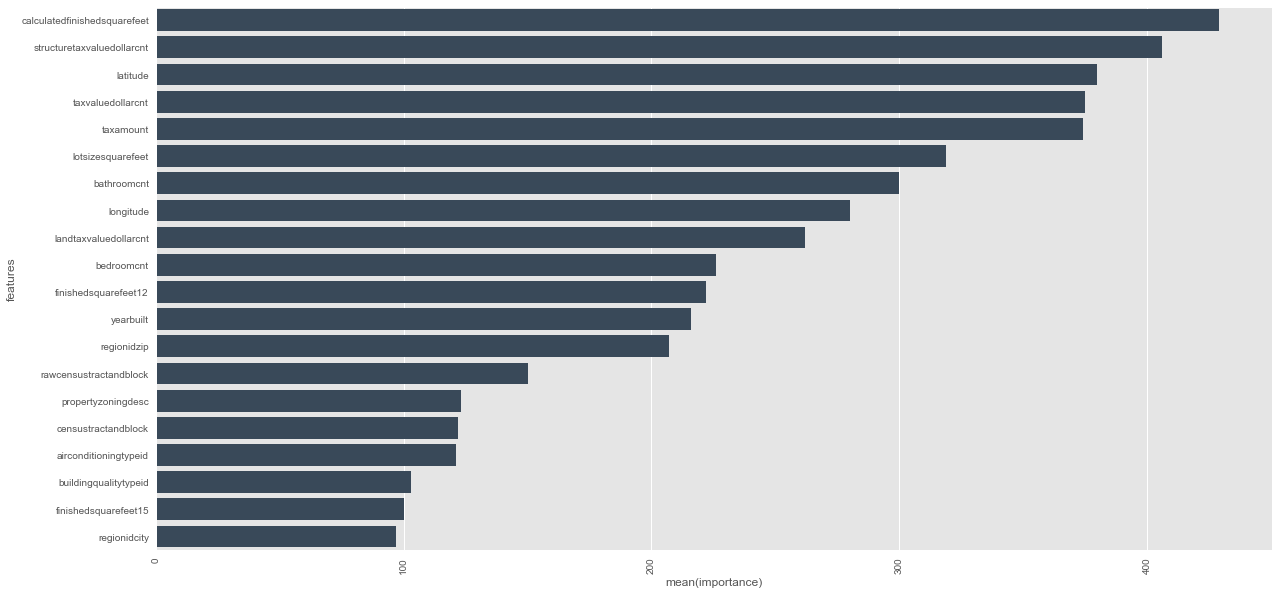

In [110]:
### Graphic representation of the top 15 features above.
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(20),x="importance",y="features",ax=ax,orient="h",color="#34495e")

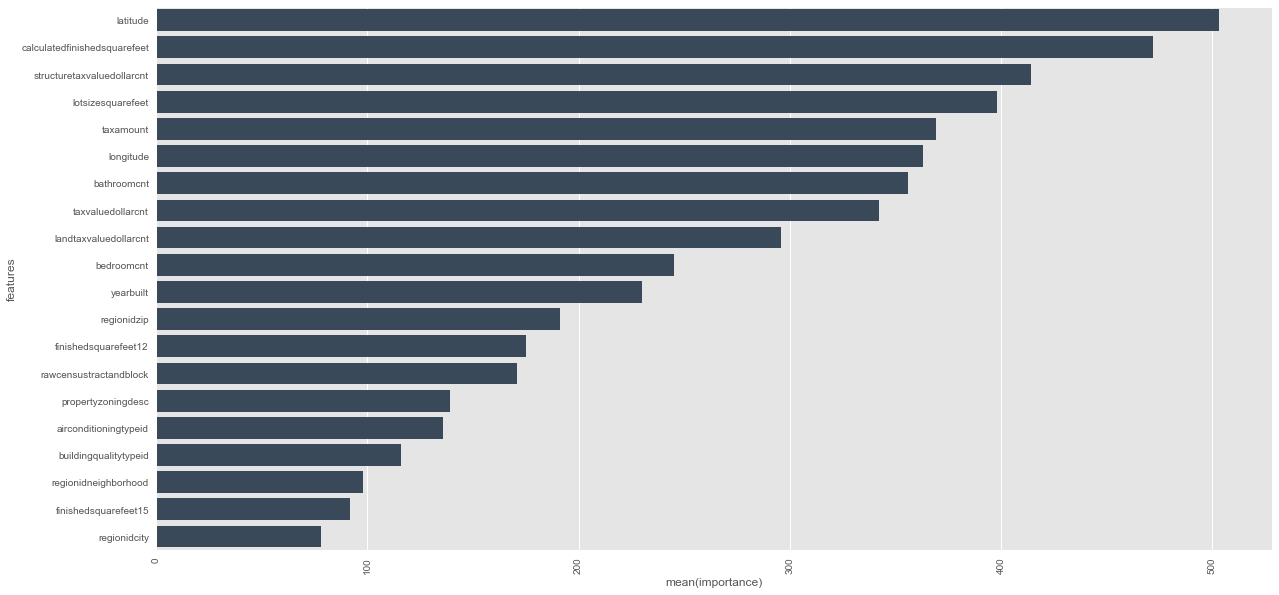

In [111]:
### Graphic representation of the top 15 features above.
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=featuresCVA.head(20),x="importance",y="features",ax=ax,orient="h",color="#34495e")

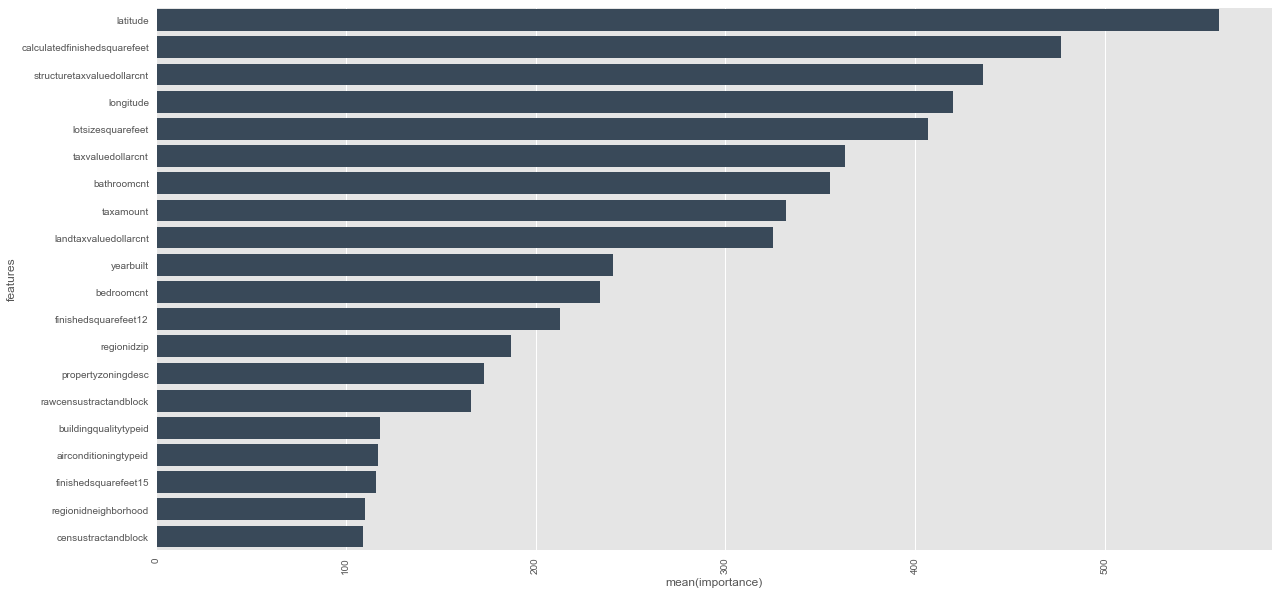

In [113]:
# Graphic representation of the top 15 features above.
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=featuresCVB.head(20),x="importance",y="features",ax=ax,orient="h",color="#34495e")

### Correlation Analysis with Heatmap

In [114]:
### Again, top 15 features
features["features"].tolist()[:15]

['calculatedfinishedsquarefeet',
 'structuretaxvaluedollarcnt',
 'latitude',
 'taxvaluedollarcnt',
 'taxamount',
 'lotsizesquarefeet',
 'bathroomcnt',
 'longitude',
 'landtaxvaluedollarcnt',
 'bedroomcnt',
 'finishedsquarefeet12',
 'yearbuilt',
 'regionidzip',
 'rawcensustractandblock',
 'propertyzoningdesc']

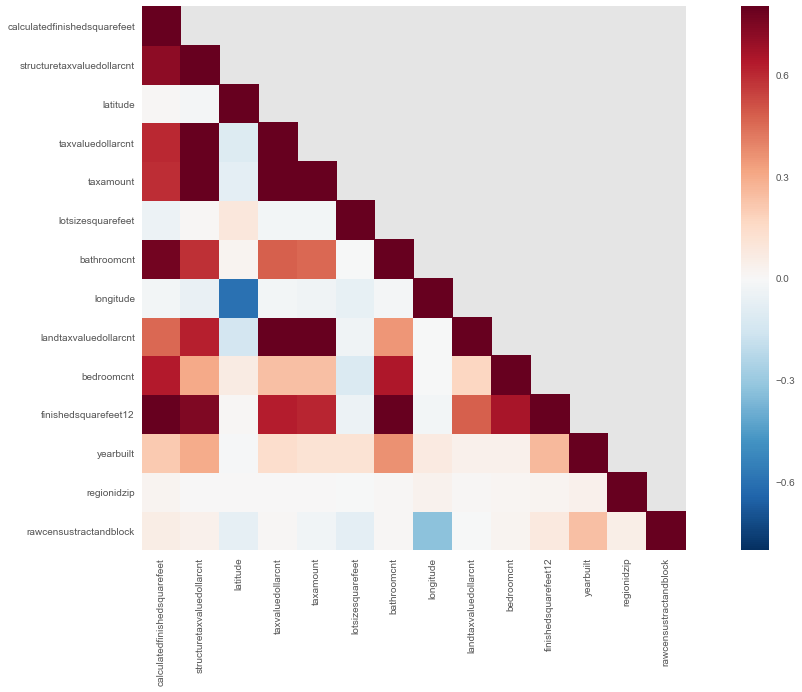

In [115]:
### As will see below, some features are heavily correlated with others:
### "taxvaluedollarcnt", "taxamount", "bathroomcnt", "landtaxvaluecnt", "finishedsquarefeet"

topFeatures = features["features"].tolist()[:15]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

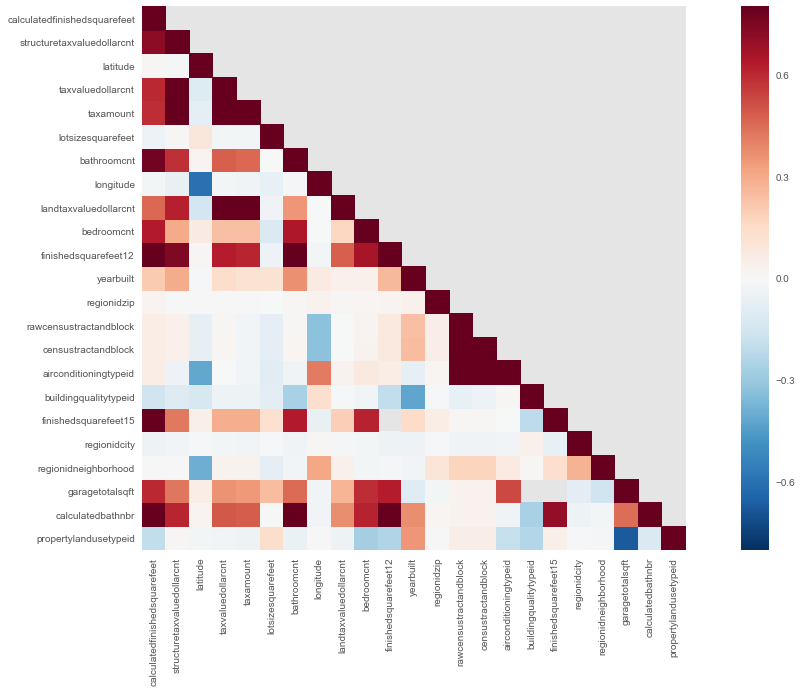

In [118]:
topFeatures = features["features"].tolist()[:25]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

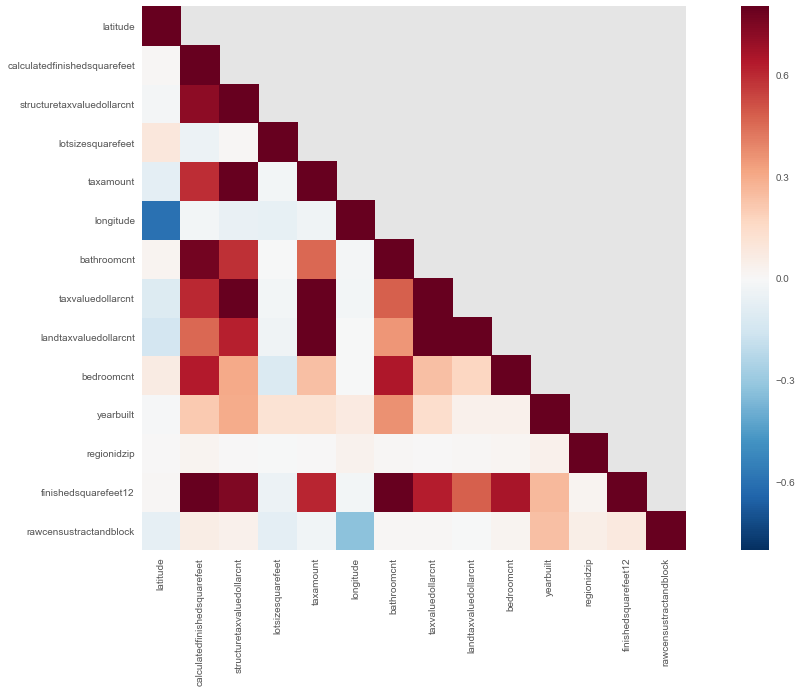

In [116]:
topFeaturesCVA = featuresCVA["features"].tolist()[:15]
corrMattCVA = merged[topFeaturesCVA].corr()
maskCVA = np.array(corrMattCVA)
maskCVA[np.tril_indices_from(maskCVA)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMattCVA, mask=mask,vmax=.8, square=True)

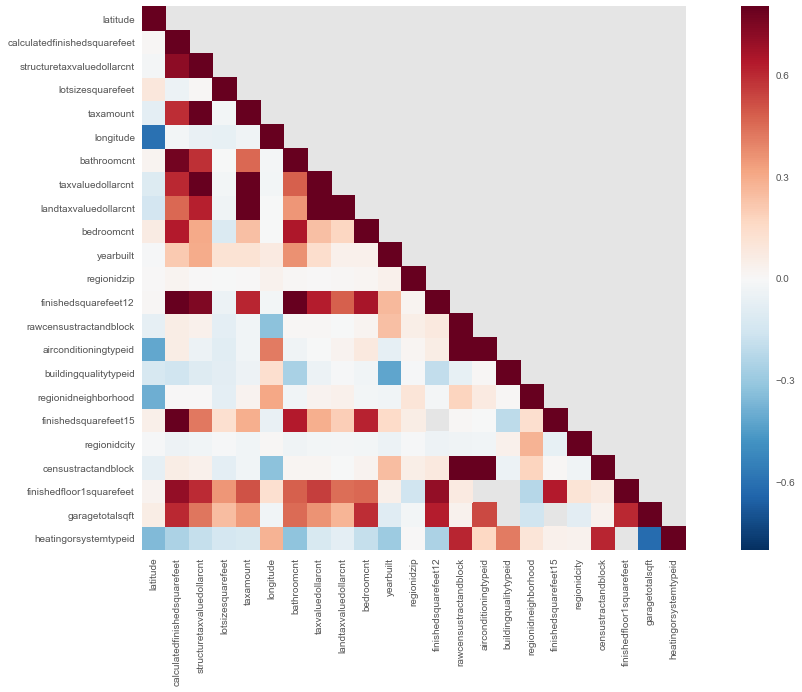

In [119]:
topFeaturesCVA = featuresCVA["features"].tolist()[:25]
corrMattCVA = merged[topFeaturesCVA].corr()
maskCVA = np.array(corrMattCVA)
maskCVA[np.tril_indices_from(maskCVA)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMattCVA, mask=mask,vmax=.8, square=True)

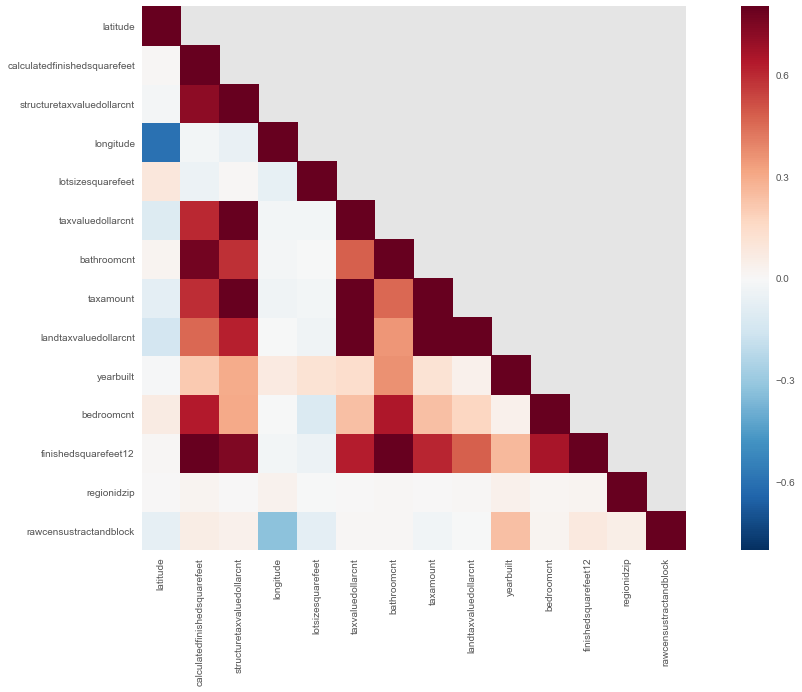

In [117]:
topFeaturesCVB = featuresCVB["features"].tolist()[:15]
corrMattCVB = merged[topFeaturesCVB].corr()
maskCVB = np.array(corrMattCVB)
maskCVB[np.tril_indices_from(maskCVB)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMattCVB, mask=mask,vmax=.8, square=True)

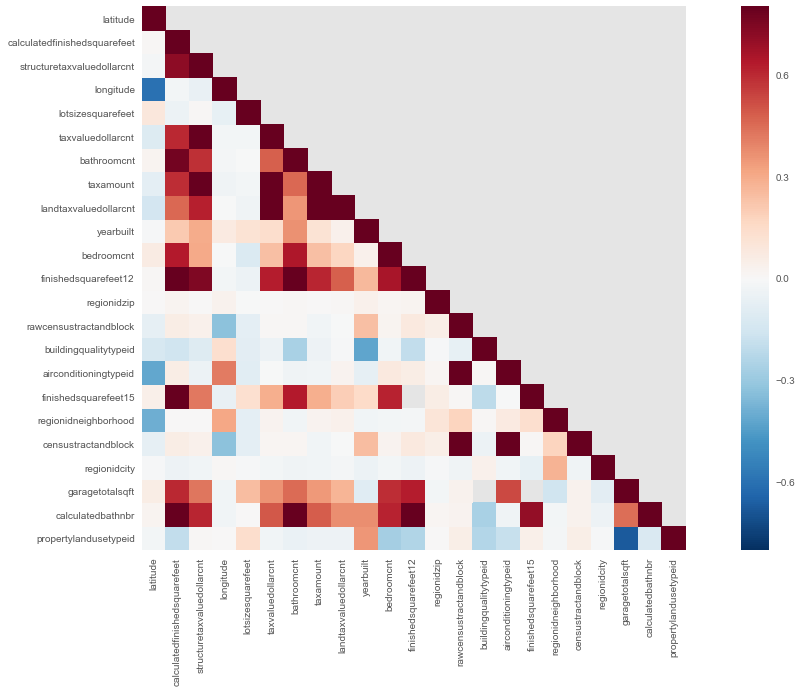

In [120]:
topFeaturesCVB = featuresCVB["features"].tolist()[:25]
corrMattCVB = merged[topFeaturesCVB].corr()
maskCVB = np.array(corrMattCVB)
maskCVB[np.tril_indices_from(maskCVB)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMattCVB, mask=mask,vmax=.8, square=True)

You can detect high-multi-collinearity by inspecting the eigen values of correlation matrix. 
A very low eigen value shows that the data are collinear, and the corresponding eigen vector shows which 
variables are collinear.
accepted
If there is no collinearity in the data, you would expect that none of the eigen values are close to zero:


each eigen vector explains the variation in the data orthogonal to other eigen vectors, and the eigen value shows 
how much variation is in that direction. 
An almost zero eigen value shows a direction with zero variation, hence collinearity

### PCA

In [121]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

In [45]:
### Train to predict logerror values
trainY = filteredMerged.logerror.values
trainX = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1)

In [46]:
X, y = filteredMerged.drop(["parcelid", "transactiondate", "logerror"], axis=1), filteredMerged.logerror.values

In [47]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1, random_state=0)

In [48]:
print (Xtrain.shape)
print (ytrain.shape)
print (Xtest.shape)
print (ytest.shape)

(81247, 57)
(81247,)
(9028, 57)
(9028,)


In [122]:
sc = StandardScaler()

In [155]:
### I've decided to use the full uploaded data for PCA and clustering purposes.

XSC = sc.fit_transform(X)

Constructing the covariance matrix
- using linalg.eig function to obtain eigenpairs

In [156]:
### Covariance Matrix in numpy, created by Standard Scaler processed training data
covMatrix = np.cov(XSC.T)

In [157]:
### Eigenvalues and eigenvectors for PCA calculation are created by using numpy linear algebra function.
eigenValues, eigenVectors = np.linalg.eig(covMatrix)

In [158]:
print("\nEigenvalues \n%s" % eigenValues)


Eigenvalues 
[  9.65952899e+00   6.70018674e+00   4.01163448e+00   2.50975032e+00
   2.37504004e+00   2.10944975e+00   1.96719432e+00   1.86770738e+00
   1.79118055e+00   1.73339094e+00   1.47538258e+00   1.21461166e+00
   1.16080895e+00   1.07610604e+00   1.03990821e+00   1.01555422e+00
   9.94441617e-01   9.88768120e-01   9.72811968e-01   9.56524371e-01
   9.15333683e-01   8.85599342e-01   8.45264003e-01   8.01000562e-01
   6.86788075e-01   6.64534519e-01   5.84737480e-01   5.22072608e-01
   4.92260458e-01   4.60818346e-01   4.42111667e-01   4.00201824e-01
   3.82691277e-01   3.41458203e-01   3.02084979e-01   2.93749555e-01
   2.30136098e-01   2.16054290e-01   1.73113158e-01   1.44140117e-01
   1.39356202e-01   1.31204749e-01   8.56225658e-02   7.25195447e-02
   6.78190863e-02   5.65817138e-02   1.82745513e-02   2.02842528e-02
   3.88398459e-03   9.07442597e-04   3.47400788e-05   2.28606061e-15
   3.82510547e-15  -4.43957406e-16   5.20304299e-16   1.79430908e-16
   0.00000000e+00]


In [159]:
print(len(eigenValues), type(eigenValues))

57 <class 'numpy.ndarray'>


Caculate cumulative sum of explained variances, then plot matplotlib "step" function

In [160]:
### Explained Variables (as per Sebastian Raschka, "Python Machine Learning")
### sorts the eigen values by descending order
Total = sum(eigenValues)
varianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)]
cumulativeVarianceExplained = np.cumsum(varianceExplained)

In [161]:
varianceExplained[:15]

[0.17248967836393916,
 0.11964486644107312,
 0.071635536411282327,
 0.044816473495646422,
 0.042410959529713993,
 0.037668328346125012,
 0.035128080912527525,
 0.033351548021946967,
 0.031985012700369866,
 0.030953066789608626,
 0.026345825571370749,
 0.02168925366885234,
 0.020728501689166894,
 0.019215966503967615,
 0.018569583710821874]

In [130]:
type(varianceExplained)  ### Type is list, the significance of this is that eigenValues above had to be summed,
                        ### Variance was calculated by i/Total, ie variance here is proportional to Total value.

list

In [131]:
cumulativeVarianceExplained[:15] ### Type np.array. Significance of this is that elements are added cumulatively,
                                 ### rather than created as a scalar.

array([ 0.17210446,  0.29165989,  0.36314276,  0.40792733,  0.45031302,
        0.48788949,  0.52298989,  0.55622737,  0.5882295 ,  0.61914414,
        0.64561349,  0.66726916,  0.6879218 ,  0.70709878,  0.72566097])

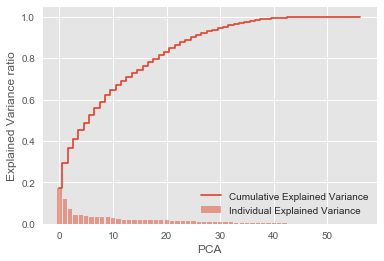

In [162]:
plt.bar(range(57),varianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(57), cumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.figure(figsize=(10,10))
plt.show()
plt.close()

In [ ]:
### Already noticeable that beyond about 30 features, very little additional information is provided.

In [163]:
### Take Top 30 dimensions, these explain easily around 97% of the variance.
BULKvarianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)][:30]
BULKcumulativeVarianceExplained = np.cumsum(BULKvarianceExplained)

In [137]:
print(len(BULKvarianceExplained))
print(len(BULKcumulativeVarianceExplained))

30
30


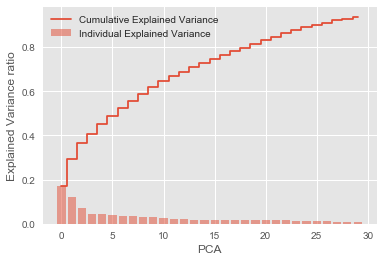

In [164]:
plt.bar(range(30),BULKvarianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(30), BULKcumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.show()
plt.close()

### Top 25 Features provide bulk of the information

In [165]:
### Top 25 dimensions, they explain ~ 92% of variance

TOPvarianceExplained = [(i/Total) for i in sorted(eigenValues, reverse=True)][:26]
TOPcumulativeVarianceExplained = np.cumsum(TOPvarianceExplained)

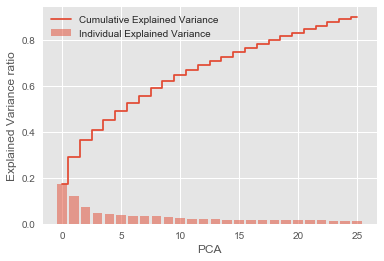

In [166]:
plt.bar(range(26),TOPvarianceExplained, alpha=0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(26), TOPcumulativeVarianceExplained, where = 'mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('PCA')
plt.legend(loc='best')
plt.show()
plt.close()

In [141]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 

In [167]:
pca = PCA(n_components=25)
analysis = pca.fit_transform(XSC)

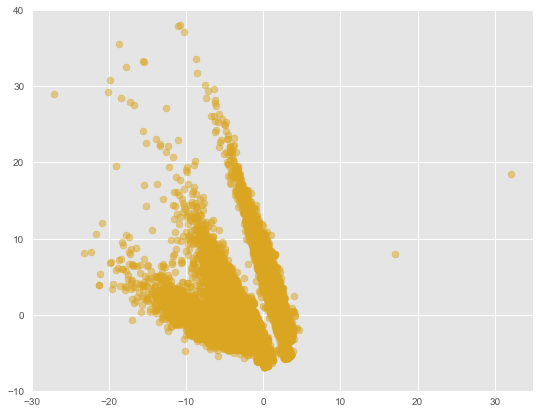

In [168]:
plt.figure(figsize = (9,7))
plt.scatter(analysis[:,0],analysis[:,1], c='goldenrod',alpha=0.5)
plt.ylim(-10,40)
plt.show()
plt.close()

In [177]:
### An alternative version of PCA to randomise features

pcaAlt = PCA(n_components='mle', whiten=True, svd_solver='full')
analysisAlt = pcaAlt.fit_transform(XSC)

In [195]:
len(analysisAlt[0,:])

56

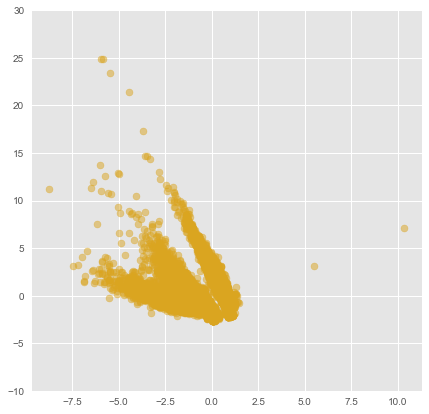

In [180]:
plt.figure(figsize = (7,7))
plt.scatter(analysisAlt[:,0],analysisAlt[:,1], c='goldenrod',alpha=0.5)
plt.ylim(-10,30)
plt.show()
plt.close()

Will see at later stages that kmeans clustering brings out similar shapes as PCA dimensionality reduction above.

Let's use Kmeans clustering to investigate data

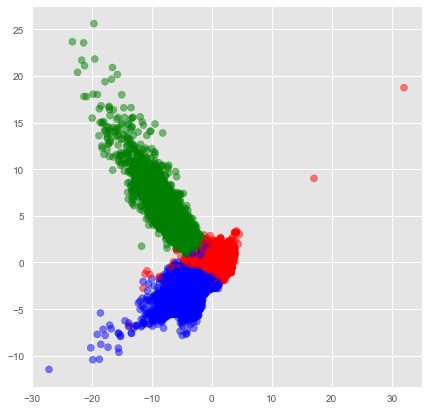

In [169]:
### VERSION I.

# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=3)
# Compute cluster centers and predict cluster indices
Xclustered = kmeans.fit_predict(analysis)

# Define our own color map
labelColourMap = {0 : 'r',1 : 'g',2 : 'b'}
labelColour = [labelColourMap[l] for l in Xclustered]

# Plot the scatter diagram
plt.figure(figsize = (7,7))
plt.scatter(analysis[:,0],analysis[:,2], c= labelColour, alpha=0.5) 
plt.show()
plt.close()

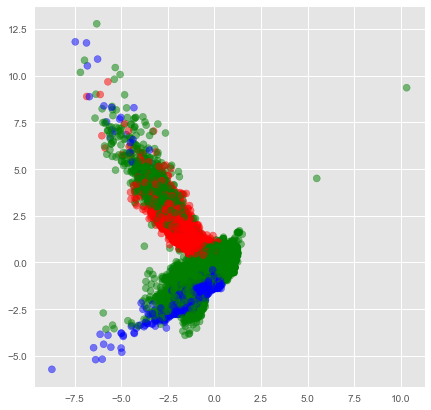

In [194]:
### VERSION II.

kmeans = KMeans(n_clusters=3)
# Compute cluster centers and predict cluster indices
XclusteredAlt = kmeans.fit_predict(analysisAlt)

# Define our own color map
labelColourMap = {0 : 'r',1 : 'g',2 : 'b', 3: 'y'}
labelColourAlt = [labelColourMap[l] for l in XclusteredAlt]

# Plot the scatter diagram
plt.figure(figsize = (7,7))
plt.scatter(x = analysisAlt[:,0],y = analysisAlt[:,2], c= labelColourAlt, alpha=0.5) 
plt.show()
plt.close()

https://stats.stackexchange.com/questions/183236/what-is-the-relation-between-k-means-clustering-and-pca

What is the relation between k-means clustering and PCA?

### Use seaborn library to explore pairwise relationships (PCA version I)

In [146]:
# Create a temp dataframe from our PCA projection data "analysis"
df5 = pd.DataFrame(analysis)
df5 = df5[[0,1,2, 3, 4]] # only want to visualise relationships between first 5 projections
df5['Xcluster'] = Xclustered

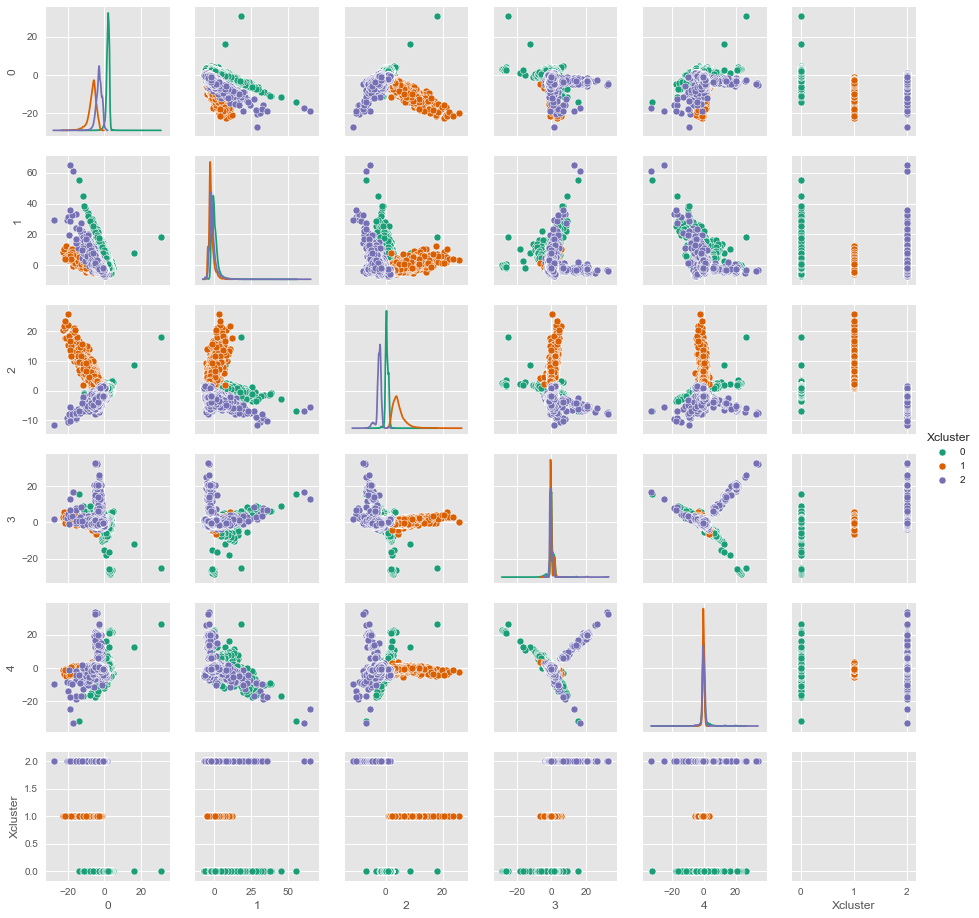

In [148]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sn.pairplot(df5, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

In [149]:
# Create a temp dataframe from our PCA projection data "analysis"
df10 = pd.DataFrame(analysis)
df10 = df10[[5, 6, 7, 8, 9]] # only want to visualise relationships between second 5 projections
df10['Xcluster'] = Xclustered

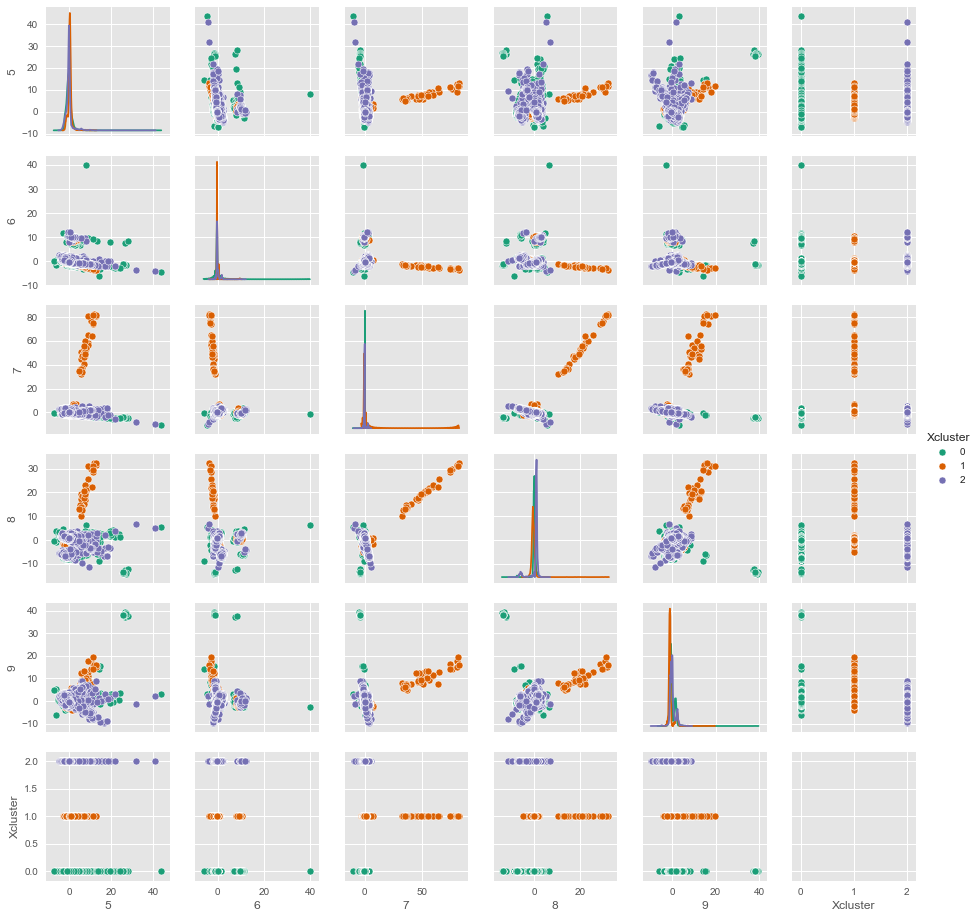

In [150]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sn.pairplot(df10, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

In [151]:
# Create a temp dataframe from our PCA projection data "analysis"
df15 = pd.DataFrame(analysis)
df15 = df15[[10, 11, 12, 13, 14]] # only want to visualise relationships between third 5 projections
df15['Xcluster'] = Xclustered

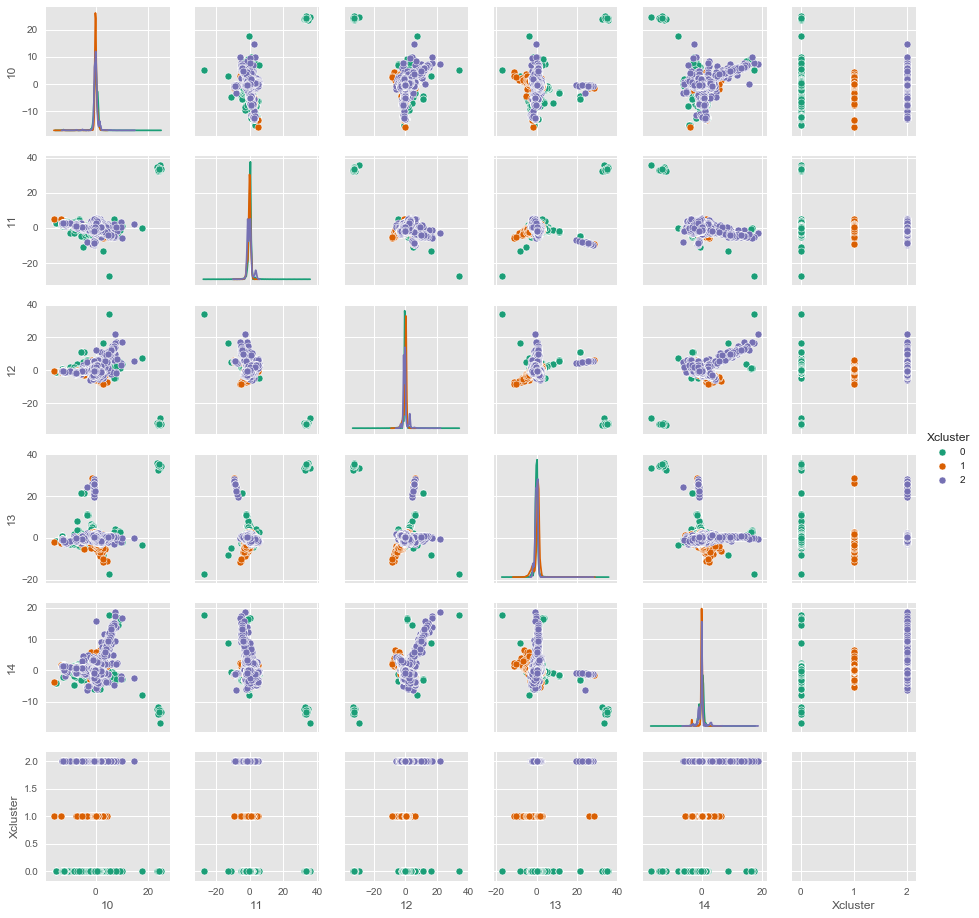

In [152]:
sn.pairplot(df15, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

In [153]:
# Create a temp dataframe from our PCA projection data "analysis"
df20 = pd.DataFrame(analysis)
df20 = df20[[15, 16, 17, 18, 19]] # only want to visualise relationships between forth 5 projections
df20['Xcluster'] = Xclustered

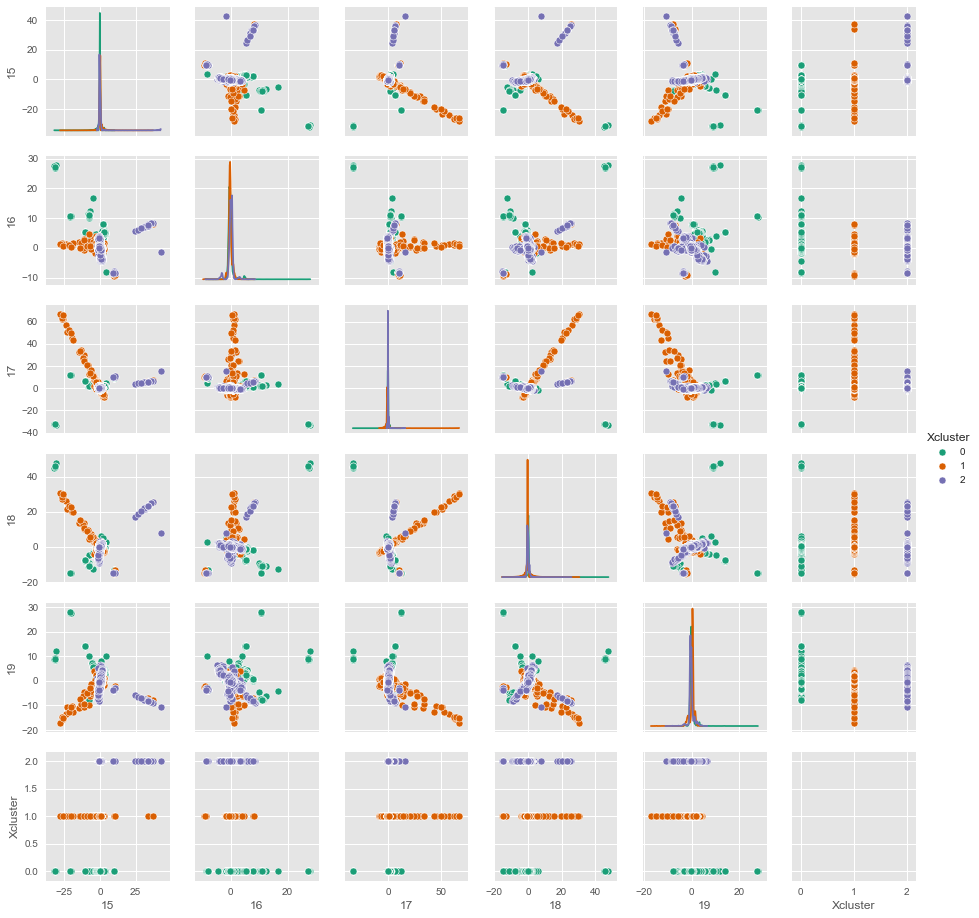

In [154]:
sn.pairplot(df20, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

In [170]:
# Create a temp dataframe from our PCA projection data "analysis"
df25 = pd.DataFrame(analysis)
df25 = df25[[20, 21, 22, 23, 24]] # only want to visualise relationships between fifth 5 projections
df25['Xcluster'] = Xclustered

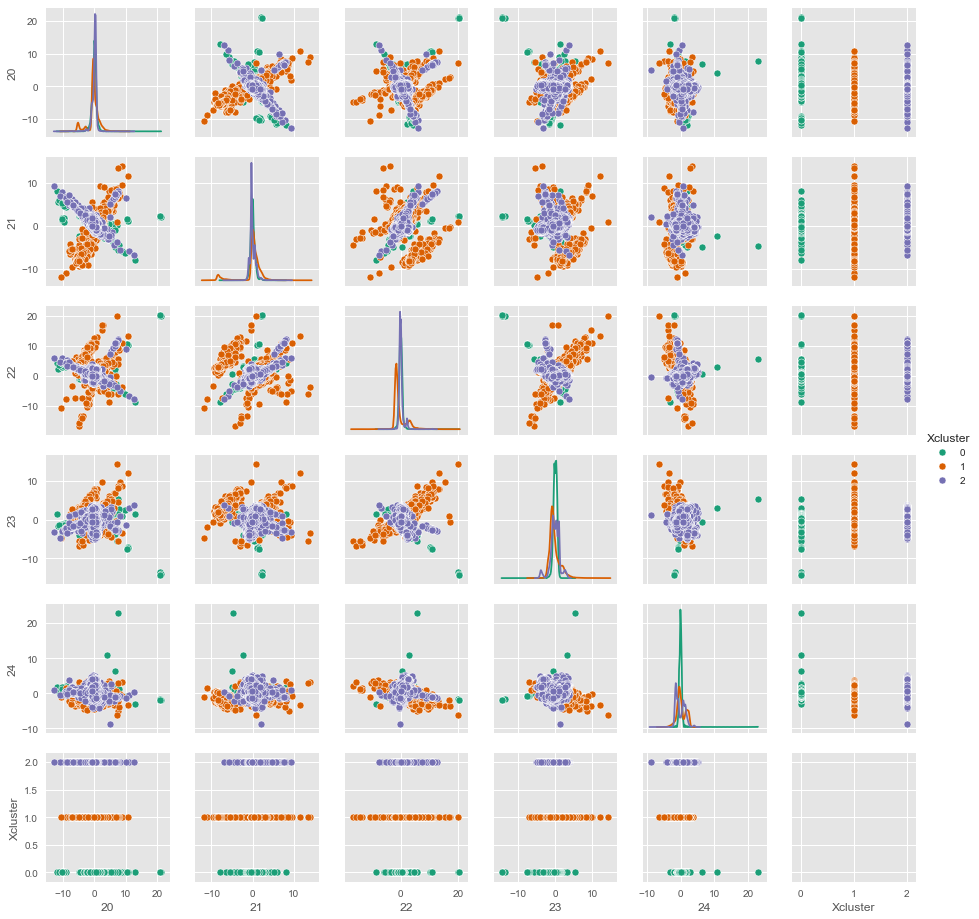

In [171]:
sn.pairplot(df25, hue='Xcluster', palette= 'Dark2', diag_kind='kde',size=2.15)

### Analysis